# Handwriting Generaton with Recurrent Neural Networks and Mixture of Gaussians

*Thomas Viehmann* <tv@learnapparat.de>

This is a PyTorch implementation of the handwriting generation in Alex Graves' classic paper [Generating Sequences with Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).
In addition to replicating the model, I wanted to explore recreating the visualisations that Graves uses.

I also studied [Alexandre de Brébisson's Theano implementation](https://github.com/adbrebs/handwriting), but all errors are my own.

I can highly recommend the original paper, I enjoyed reading it a lot.

**Note:** This notebook is written using PyTorch 0.4 (master at the time of writing).

At popular request, I have you can get [pretrained model weights](https://github.com/t-vi/pytorch-tvmisc/releases/download/2018-03-13/graves_handwriting_generation_2018-03-13-02-45epoch_49.hd5). Use them with the load_from_hdf5 code below. They are not particularly tweaked but just the ones that I got when I ran the notebook for the outputs you see below.

## Overview
Besically we have the following architecture (shown in the diagram):
- The triplets of relative movements in $x$ and $y$ direction and $pen$ (note this is different to Graves' notation, who uses $x$ for the triple) and a (attention-) mixture $w$ of one-hot encoded characters are fed into an **LSTM**, producing a hidden state $h$.
- The **Attention** takes the sequence of one-hot encoded characters ($c$ in Graves) and the hidden state $h$ to weight $c$ and give a new mixture $w$ of $c$ items. The attention component remembers the location of the attention modes.
- A **Mixture Density Network** (see [a short notebook here](https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/Mixture_Density_Network_Gaussian_1d.ipynb)) takes the LSTM output $h$ and the attention-modulated character information $w$ to compute a Gaussian density mixture for the coordinates and a Bernoulli parameter for pen up/pen down. In training the negative log likelihood of the actual movement and pen is used, and for prediction, movement and pen are sampled.
- A module wraps the three components and steps through the sequence.

(I honestly don't know how to make those esges between timesteps closer...)


In [ ]:
import graphviz
g = graphviz.Digraph(graph_attr=dict(size="12,12"))
with g.subgraph() as dot:
    g.node("pts(t-1)",label="(X,Y,Pen)(t-1)", shape="ellipse", style="filled")
    g.node("txt",label="Text", style="filled")
    g.node("w(t-1)", style="filled")
    g.edge("pts(t-1)","txt", style="invis")
    g.edge("txt","w(t-1)", style="invis")
for i,timestep in enumerate(["t","t+1", "t+2"]):
    with g.subgraph(name="cluster_{}".format(timestep)) as dot:
        dot.attr(label='Step {}'.format(timestep))
        dot.attr(sortv=str(i+1))
        dot.node("LSTM{}".format(timestep),label="LSTM", shape="box", style="rounded")
        dot.node("GMM{}".format(timestep),label="Mixture Density", shape="box", style="rounded")
        dot.node("ATT{}".format(timestep),label="Attention", shape="box", style="rounded")
        dot.node("pts({})".format(timestep),label="(X,Y,Pen)({})".format(timestep), shape="ellipse", style="filled")
        dot.node("h({})".format(timestep), shape="ellipse", style="filled")
        dot.node("w({})".format(timestep), shape="ellipse", style="filled")
        dot.edge("h({})".format(timestep), "ATT{}".format(timestep))
        dot.edge("LSTM{}".format(timestep),"h({})".format(timestep))
        dot.edge("h({})".format(timestep), "GMM{}".format(timestep))
        dot.edge("ATT{}".format(timestep), "w({})".format(timestep))
        dot.edge("w({})".format(timestep), "GMM{}".format(timestep))
        dot.edge("GMM{}".format(timestep), "pts({})".format(timestep), style="dashed", label="predict")


g.edge("pts(t-1)", "LSTMt", constraint="false")
g.edge("w(t-1)", "LSTMt", constraint="false")
g.edge("txt", "ATTt", constraint="false")
g.edge("txt", "ATTt+1", constraint="false")
g.edge("txt", "ATTt+2", constraint="false")
g.edge("w(t)","LSTMt+1",constraint="false")
g.edge("w(t+1)","LSTMt+2",constraint="false")
g.edge("pts(t)","LSTMt+1",constraint="false")
g.edge("pts(t+1)","LSTMt+2",constraint="false")
g

First let us import something.

In [1]:
import os
import sys
import pickle
import time
import collections
import numpy
import IPython
import cairocffi as cairo
from matplotlib import pyplot
import matplotlib
import torchtext
import tqdm
import glob
import lxml.etree
%matplotlib inline
import torch
torch.manual_seed(42)

## The dataset

The [IAM Online Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-online-document-database/iam-online-document-database) is provided by [E. Indermühle, M. Liwicki, and H. Bunke: IAMonDo-database: an Online Handwritten Document Database with Non-uniform Contents. Proc 9th Int. Workshop on Document Analysis Systems, 2010.](http://www.fki.inf.unibe.ch/databases/iam-online-document-database/das10db.pdf).

The set is split into a training and three test sets, the latter being labeled *v*, *f*, and *t*. Following Graves, Section 4, we use the *v* set as validation and combine the other three for training.

I used to have a separate preprocessing notebook, but preprocessing takes less than 30 seconds for me, so I just moved it here...

In [2]:
iam_dir = "data/iam/"
orig_trainset = [l.strip() for l in open(os.path.join(iam_dir, "trainset.txt"))]
orig_testset_v = [l.strip() for l in open(os.path.join(iam_dir, "testset_v.txt"))] # smallest
orig_testset_f = [l.strip() for l in open(os.path.join(iam_dir, "testset_f.txt"))]
orig_testset_t = [l.strip() for l in open(os.path.join(iam_dir, "testset_t.txt"))]

trainset = orig_trainset + orig_testset_f + orig_testset_t
validset = orig_testset_v


The dataset contains ascii files with the text and xml-based representations of the strokes.

In [5]:
blacklist = {"a08-551z-08","a08-551z-09"} # these seem broken

def process_set(theset):
    txts = {}
    for i,n in enumerate(theset):
        txtfn = "data/iam/ascii/{}/{}/{}.txt".format(n[:3], n[:7], n)
        for j,t in enumerate(open(txtfn).read().split("CSR:")[1].strip().split("\n")):
            txts['{}-{:02d}'.format(n,j+1)] = t
    samples = {}
    for i,n in tqdm.tqdm(enumerate(theset),total=len(theset)):
        globmask = "data/iam/lineStrokes/{}/{}/{}-*.xml".format(n[:3], n[:7], n)
        for fn in glob.glob(globmask):
            key = (os.path.splitext(os.path.basename(fn))[0])
            if key not in blacklist:
                root = lxml.etree.parse(fn).getroot()
                strokes_list = []
                for s in root.find("StrokeSet").findall("Stroke"):
                    pts = torch.FloatTensor([(float(p.attrib['x']), float(p.attrib['y']),0.0) for p in s.findall("Point")])
                    pts[-1,-1] = 1
                    strokes_list.append(pts)
                strokes = torch.cat(strokes_list, dim=0)
                (min_x,min_y),_ = torch.min(strokes[:,:2],dim=0)
                (max_x,max_y),_ = torch.max(strokes[:,:2],dim=0)
                rel_strokes = torch.cat([torch.zeros(1,3),
                                         torch.cat([strokes[1:,:2]-strokes[:-1,:2],strokes[1:,2:]],dim=1)], dim=0)
                if rel_strokes.abs().max()<1000: # we assume that such large moves are broken
                    samples[key] = {"strokes":strokes_list, "minmax":(min_x,min_y,max_x,max_y), "rel_strokes":rel_strokes,
                                    "txt": txts[key]}
    return samples


In [6]:
training_samples = process_set(trainset)
#torch.save(training_samples, "preprocessed-training.pt")
val_samples = process_set(validset)
#torch.save(val_samples, "preprocessed-validation.pt")


100%|██████████| 192/192 [00:06<00:00, 29.22it/s]


In [7]:
x = torch.cat([d["rel_strokes"] for d in training_samples.values()], dim=0)
mean,std = x[:,:2].mean(0),x[:,:2].std(0)
print ("mean", mean, "std", std)

mean tensor([8.1842, 0.1145]) std tensor([40.3660, 37.0441])


We use a torchtext dataset to use our preprocessed IAM online handwriting data.

In [8]:
char_dict = {k:v for v,k in enumerate(' !"#%&\'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz')}
inv_char_dict = {v:k for k,v in char_dict.items()}
n_chars = len(char_dict)

class DS(torchtext.data.Dataset):
    def __init__(self, samples, mean, std):
        self.myfields = [('txt',torchtext.data.Field(use_vocab=True,tokenize=list, eos_token='<eos>')), 
                         ('txtn',torchtext.data.Field(use_vocab=False,pad_token=0)), 
                         ('txtlen',torchtext.data.Field(use_vocab=False)),
                         ('txtmask',torchtext.data.Field(use_vocab=False,pad_token=0, dtype=torch.float)),
                         ('xs',torchtext.data.Field(use_vocab=False, pad_token=-1, dtype=torch.float)),
                         ('ys',torchtext.data.Field(use_vocab=False, pad_token=-1, dtype=torch.float)),
                         ('pen',torchtext.data.Field(use_vocab=False,pad_token=-1)),
                         ('ptslen',torchtext.data.Field(use_vocab=False))
                        ]
        self.coord_mean = mean
        self.coord_std  = std
        examples = []
        for s in samples.values():
            txt = [c for c in s["txt"] if c in char_dict]
            txtn = torch.LongTensor([char_dict[i] for i in txt])
            txtlen = torch.LongTensor([len(txt)])
            txtmask = torch.ones(len(txt))
            stroke = s['rel_strokes']
            xs = stroke[:,0]
            ys = stroke[:,1]
            pen = stroke[:,2]
            ptslen = torch.LongTensor([len(pen)])
            if xs.abs().max()<1000 and ys.abs().max()<1000 and len(txt)>=20:
                xs = (xs-self.coord_mean[0])/self.coord_std[0]
                ys = (ys-self.coord_mean[1])/self.coord_std[1]
                examples.append(torchtext.data.Example.fromlist([txt, txtn, txtlen, txtmask,
                                                            xs, ys, pen, ptslen
                                                            ], self.myfields))        
        super(DS, self).__init__(examples, self.myfields)
        self.myfields[0][1].build_vocab(self)
    def sort_key(self, ex):
        return len(ex.txt)
    def tensor_to_str(self,t):
        return ''.join([self.fields['txt'].vocab.itos[c] for c in t if c >= 3])
    def tensor_to_str2(self,t):
        return ''.join([inv_char_dict[c] for c in t])

train_ds = DS(training_samples, mean, std)
val_ds   = DS(val_samples, mean, std)



Here is both a matplotlib-based and a cairo-based function to display a stroke.
The cairo-based function is a lot faster and optionally add random shear and rotation, the matplotlib-based one offers color.

In [9]:
def show_stroke(x, colors=None):   
    x= x[:(torch.arange(0,x.size(0))[x[:,2]>-0.0001].size(0))] # only used bits
    stroke = (x[:,:2]*train_ds.coord_std.unsqueeze(0)+train_ds.coord_mean.unsqueeze(0)).cumsum(0)
    stroke[:,1] *= -1
    pen = x[:,2]
    xmin,ymin = stroke.min(0)[0]
    xmax,ymax = stroke.max(0)[0]
    
    actions = [matplotlib.path.Path.MOVETO]
    coords = []
    for c,p in zip(stroke, pen):
        if p >=-0.0001:
          if p==1 or len(actions)==0:
            actions.append(matplotlib.path.Path.MOVETO)
          else:
            actions.append(matplotlib.path.Path.LINETO)
          coords.append((c[0],c[1]))
    actions = actions[:-1]
    ax = pyplot.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    if colors is None:
        path = matplotlib.path.Path(coords, actions)
        patch = matplotlib.patches.PathPatch(path, facecolor='none')
        ax.add_patch(patch)
    else:
        pos = coords[0]
        curpos = pos
        for pos,a,col in zip(coords, actions, colors):
            if a == matplotlib.path.Path.LINETO:
                ax.add_line(matplotlib.lines.Line2D((curpos[0],pos[0]), (curpos[1],pos[1]), axes=ax, color=col))
            curpos = pos


def stroke_to_image(x, target_size = (1280,64), randomize=False):
    stroke = (x[:,:2]*train_ds.coord_std.unsqueeze(0)+train_ds.coord_mean.unsqueeze(0)).cumsum(0)
    pen = x[:,2]
    if randomize:
        shear_prob = 0.5
        shear_prec = 4.0
        if torch.rand(1)[0] > shear_prob:
            shear_sigma = 1/shear_prec**0.5
            shear_theta = 0.5*torch.randn(1)    
        else:
            shear_theta = torch.zeros(1)
        rot_prob = 0.5
        rot_prec = 4.0
        if torch.rand(1)[0] > rot_prob:
            rot_sigma = 1/rot_prec**0.5
            rot_theta = 0.5*torch.randn(1)    
        else:
            rot_theta = torch.zeros(1)

        (min_x,min_y),_ = torch.min(stroke[:,:2],dim=0)
        (max_x,max_y),_ = torch.max(stroke[:,:2],dim=0)
        stroke[:,0] -= min_x
        stroke[:,1] -= min_y  
        min_x, min_y = 0.0,0.0
        max_x, max_y = max_x-min_x, max_y-min_y

        stroke[:,0] += stroke[:,1]*torch.sin(shear_theta)

        stroke[:,0] = stroke[:,0]*torch.cos(rot_theta)+stroke[:,1]*torch.sin(rot_theta)
        stroke[:,1] = stroke[:,1]*torch.cos(rot_theta)-stroke[:,0]*torch.sin(rot_theta)

    (min_x,min_y),_ = torch.min(stroke[:,:2],dim=0)
    (max_x,max_y),_ = torch.max(stroke[:,:2],dim=0)
    stroke[:,0] -= min_x
    stroke[:,1] -= min_y  
    min_x, min_y = 0.0,0.0
    max_x, max_y = max_x-min_x, max_y-min_y

    factor = min(target_size[0]/max(max_x-min_x,0.001),target_size[1]/max(max_y-min_y,0.001),1)
    xmin,ymin = stroke.min(0)[0]
    xmax,ymax = stroke.max(0)[0]

    imwidth, imheight = int(xmax*factor)+2, int(ymax*factor)+2
    surface = cairo.ImageSurface (cairo.FORMAT_A8, imwidth, imheight)
    ctx = cairo.Context(surface)

    ctx.scale (factor, factor) # Normalizing the canvas
    ctx.rectangle (0, 0, xmax+5/factor, ymax+5/factor) # Rectangle(x0, y0, x1, y1)
    ctx.set_source_rgba (0.0, 0.0, 0.0, 0.0) # Solid color
    ctx.fill ()
    next_action = 1
    coords = []
    for c,p in zip(stroke, pen):
        if p >=-0.0001:
          if next_action:
            ctx.move_to(c[0]+1,c[1]+1)
          else:
            ctx.line_to(c[0]+1,c[1]+1)
          next_action = p>0.5
    ctx.set_source_rgba(1.0, 1.0, 1.0, 1.0) # Solid color

    
    if randomize:
        linewidth = (1+torch.rand(1)[0])/factor
    else:
        linewidth = 2/factor
    ctx.set_line_width (linewidth)
    ctx.stroke ()

    buf = surface.get_data()
    data = numpy.ndarray(shape=(imheight, (imwidth+3)//4*4),#(WIDTH+7)//8),
                         dtype=numpy.uint8,
                         buffer=buf)[:,:imwidth]
    data = 1-(data>0)
    data = torch.FloatTensor(data)
    return data


Let us see an example of our data:

'at Lancaster House despite the crisis which'

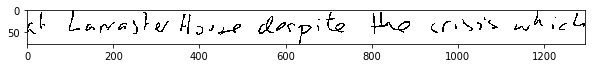

In [10]:
b = train_ds[0]
pts = torch.stack([b.xs,b.ys,b.pen.float()],dim=-1)
pyplot.figure(figsize=(10,5))
pyplot.imshow(stroke_to_image(pts[:b.ptslen[0]].cpu()), cmap=pyplot.cm.gray)
''.join(b.txt)


## The network

### Mixture Density Network

The mixture density network, described in Graves Section 4.1, consists of a linear layer and parameter transforms in `compute_params`.
The parameters are
- a vector $\pi$ with the weights of the mixture components, 
- vectors (one element per mixture component)`mean_x, mean_y` ($\mu$ in Graves), `std_x, std_y` ($\sigma$), and $\rho$,
- a probaility `bernoulli` ($e$ in Graves) of the pen being up (i.e. $1$ means no pen).

Then for training (in `forward`), the negative log likelihood is computer. For prediction (`predict`), movement and pen indicator are sampled.
In the prediction, we allow for bias ($b$) as in Graves Section 5.4.

We found that the training sometimes runs into `NaN` unless we use some regularisation, we do so via a parameter `eps`.
This may be due to us using single precision floating point numbers rather than double precision or a too aggressive learning rate.
We also see below that we do not seem to achieve the deterministic outputs when the bias is high.


In [11]:
class MixtureGaussians2DandPen(torch.nn.Module):
    """Gaussian mixture module as in Graves Section 4.1"""
    def __init__(self, n_inputs, n_mixture_components, eps=1e-6):
        # n_inputs = dimension N of h^n_t in Graves eq. (17)
        # n_mixture_components = number M of mixture components in Graves eq. (16)
        super().__init__()
        self.n_mixture_components = n_mixture_components
        self.eps = eps
        # linear layer as in Graves eq. (17)
        # ((proportions, m_x, m_y, s_x, s_y, rho)*n_mixture_components, pen)
        self.linear = torch.nn.Linear(n_inputs, n_mixture_components *6 + 1) 

    def compute_parameters(self, h, bias):
        # h: batch x n_inputs
        # The output of the input layer is batch x ...
        y_hat = self.linear(h)
        if y_hat.requires_grad:
            y_hat.register_hook(lambda x: x.clamp(min=-100, max=100))
        
        M = self.n_mixture_components
        # note that our ordering within y_hat is different to Graves eq (17)
        # we also incorporate the bias b given in Graves eq (61) and (62)
        # we have a regularisation self.eps that Graves does not have in the paper
        pi = torch.nn.functional.softmax(y_hat[:, :M]*(1 + bias),1) # Graves eq (19)
        mean_x = y_hat[:, M:M*2]                                      # Graves eq (20)
        mean_y = y_hat[:, M*2:M*3]
        std_x = torch.exp(y_hat[:, M*3:M*4] - bias) + self.eps        # Graves eq (21)
        std_y = torch.exp(y_hat[:, M*4:M*5] - bias) + self.eps
        rho = torch.tanh(y_hat[:, M*5:M*6])                           # Graves eq (22)
        rho = rho/(1+self.eps)
        bernoulli = torch.sigmoid(y_hat[:, -1])                       # Graves eq (18)
        bernoulli = (bernoulli + self.eps) / (1 + 2*self.eps)
        #bernoulli = 1/(1+torch.exp(-(1+bias)*((torch.log(bernoulli)-torch.log(1-bernoulli))+3*(1-torch.exp(-bias))))) # this is NOT covered by Graves: Bias in the Bernoulli
        return pi, mean_x, mean_y, std_x, std_y, rho, bernoulli

    def predict(self, h, bias=0.0):
        pi, mean_x, mean_y, std_x, std_y, rho, bernoulli = self.compute_parameters(h, bias)

        mode = torch.multinomial(pi.data,1) # choose one mixture component

        m_x = mean_x.gather(1, mode).squeeze(1) # data for the chosen mixture component
        m_y = mean_y.gather(1, mode).squeeze(1)
        s_x = std_x.gather(1, mode).squeeze(1)
        s_y = std_y.gather(1, mode).squeeze(1)
        r   = rho.gather(1, mode).squeeze(1)

        normal = rho.new().resize_((h.size(0), 2)).normal_()
        x = normal[:, 0]
        y = normal[:, 1]

        x_n = (m_x + s_x * x).unsqueeze(-1)
        y_n = (m_y + s_y * (x * r + y * (1.-r**2)**0.5)).unsqueeze(-1)

        uniform = bernoulli.data.new(h.size(0)).uniform_()
        pen = torch.autograd.Variable((bernoulli.data > uniform).float().unsqueeze(-1))

        return torch.cat([x_n, y_n, pen], dim=1)

    def forward(self, h_seq, mask_seq, tg_seq, hidden_dict=None):
        # h_seq: (seq, batch, features),  mask_seq: (seq, batch), tg_seq: (seq, batch, features=3)
        batch_size = h_seq.size(1)
        h_seq = h_seq.view(-1, h_seq.size(-1))
        tg_seq = tg_seq.view(-1, tg_seq.size(-1))
        mask_seq = mask_seq.view(-1,)

        atensor = next(self.parameters())
        bias = torch.zeros((),device=atensor.get_device(), dtype=atensor.dtype)
        pi, mean_x, mean_y, std_x, std_y, rho, bernoulli = self.compute_parameters(h_seq, bias)

        if hidden_dict is not None:
            hidden_dict["pi"].append(pi.data.cpu())
            hidden_dict["mean_x"].append(mean_x.data.cpu())
            hidden_dict["mean_y"].append(mean_y.data.cpu())
            hidden_dict["std_x"].append(std_x.data.cpu())
            hidden_dict["std_y"].append(std_y.data.cpu())
            hidden_dict["rho"].append(rho.data.cpu())
            hidden_dict["bernoulli"].append(bernoulli.data.cpu())

        tg_x = tg_seq[:, 0:1]
        tg_y = tg_seq[:, 1:2]
        tg_pen = tg_seq[:, 2]

        tg_x_s = (tg_x - mean_x) / std_x 
        tg_y_s = (tg_y - mean_y) / std_y

        z = tg_x_s**2 + tg_y_s**2 - 2*rho*tg_x_s*tg_y_s # Graves eq (25)
        
        if hidden_dict is not None:
            hidden_dict["z"].append(z.data.cpu())            

        tmp = 1-rho**2
        # tmp is ln (pi N(x, mu, sigma, rho)) with N as in Graves eq (24) (this is later used for eq (26))
        mixture_part_loglikelihood = (-z / (2 * tmp) 
                              -numpy.log(2*numpy.pi) - torch.log(std_x) - torch.log(std_y) - 0.5*torch.log(tmp)
                              +torch.log(pi))

        # logsumexp over the mixture components
        # mixture_log_likelihood the log in the first part of Graves eq (26)
        mpl_max,_ = mixture_part_loglikelihood.max(1, keepdim=True)                                 
        mixture_log_likelihood = (mixture_part_loglikelihood-mpl_max).exp().sum(1).log()+mpl_max.squeeze(1)

        # these are the summands in Graves eq (26)
        loss_per_timestep = (-mixture_log_likelihood - tg_pen * torch.log(bernoulli) - (1-tg_pen) * torch.log(1 - bernoulli))

        if hidden_dict is not None:
            hidden_dict["loss_per_timestep"].append(loss_per_timestep.data.cpu())
        # loss as in Graves eq (26)
        loss = torch.sum(loss_per_timestep * mask_seq)/batch_size
        return loss

### Attention Mechanism

Graves Section 5.1 describes a straightforward attention mechanism using a mixture-type weighting scheme and with moving modes.
In addition to the one-hot encoded character sequence, the input for the attention mechanism is the LSTM-output $h$ and the previous time-steps mode locations $\kappa_{t-1}^k$.
More precisely, weights $\phi$ are computed as
$$
\phi(t, u) = \sum_k \alpha_t^k \exp(-\beta_t^k (\kappa_t^k-u)^2)
$$
with $t$ being the recurrence time step, $u$ the character location and $k$ is used to sum over the components.
Here, $\alpha_t^k, \beta_t^k$ and $\kappa_t^k-\kappa_{t-1}^k$ are positive - mapped by $\exp$ from the output of a linear layer. For the $\kappa_t^k$, the difference is modelled to achieve better stationarity.
The module returns the weight vector $\phi$ and the mode location vector $\kappa$.

Graves notes he does not normalize the weights.

In [12]:
class Attention(torch.nn.Module):
    def __init__(self, n_inputs, n_mixture_components):
        super().__init__()
        self.n_mixture_components = n_mixture_components
        # linear layer from Graves eq (28)
        self.linear = torch.nn.Linear(n_inputs, n_mixture_components*3)
    def forward(self, h_1, kappa_prev, c_seq_len):
        # h_1: batch x n_inputs, kappa_prev batch x n_mixture_components
        K = self.n_mixture_components
        params = torch.exp(self.linear(h_1)) # exp of Graves eq (48)
        alpha = params[:,:K]                 # Graves eq (49)
        beta  = params[:,K:2*K]              # Graves eq (50)
        kappa = kappa_prev + 0.1*params[:,2*K:]  # Graves eq (51)
        u = torch.arange(0,c_seq_len, out=kappa.new()).view(-1,1,1)
        phi = torch.sum(alpha * torch.exp(-beta*(kappa-u)**2), dim=-1)
        return phi, kappa


### LSTM

In order to be able to trade the LSTM cell for a GRU, I have a thin wraper around the LSTMCell module.

In [13]:
class RNNCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = torch.nn.LSTMCell(input_size, hidden_size, bias)
    def forward(self, inp, hidden = None):
        if hidden is None:
            batch_size = inp.size(0)
            hx = inp.new(batch_size, self.hidden_size).zero_()
            cx = inp.new(batch_size, self.hidden_size).zero_()
            hidden = (hx, cx)
        return self.cell(inp, hidden)
    def get_hidden(self, hidden):
        return hidden[0]


### Main Module

Tying things together is the main module. It is disappointingly heavyweight given that it mostly does administraton.


In [14]:
class HandwritingModel(torch.nn.Module):
    def __init__(self, n_hidden, n_chars, n_attention_components, n_gaussians, grad_clipping=10):
        super(HandwritingModel, self).__init__()
        self.n_hidden = n_hidden
        self.n_chars = n_chars
        self.n_attention_components = n_attention_components
        self.n_gaussians = n_gaussians

        self.attention = Attention(n_hidden, n_attention_components)
        self.rnn_cell = RNNCell(3+self.n_chars, n_hidden)
        self.grad_clipping = grad_clipping
        self.mixture = MixtureGaussians2DandPen(n_hidden+self.n_chars, n_gaussians)

    def rnn_step(self, inputs, h_state_pre, k_pre, w_pre, c, c_mask, mask=None, hidden_dict=None):
        # inputs: (batch_size, n_in + n_in_c)
        inputs = torch.cat([inputs, w_pre], dim=1)

        # h: (batch_size, n_hidden)
        h_state = self.rnn_cell(inputs, h_state_pre)
        h = self.rnn_cell.get_hidden(h_state)
        if h.requires_grad:
            h.register_hook(lambda x: x.clamp(min=-self.grad_clipping, max=self.grad_clipping))
            
        # update attention
        phi, k =  self.attention(h, k_pre, c.size(0))
        phi = phi * c_mask
        # w: (batch_size, n_chars)
        w = torch.sum(phi.unsqueeze(-1) * c, dim=0)
        if mask is not None:
            k = mask.unsqueeze(1)*k + (1-mask.unsqueeze(1))*k_pre
            w = mask.unsqueeze(1)*w + (1-mask.unsqueeze(1))*w_pre
        if w.requires_grad:
            w.register_hook(lambda x: x.clamp(min=-100, max=100))
        return h_state, k, phi, w
    
    def forward(self, seq_pt, seq_mask, seq_pt_target, c, c_mask,
                h_ini=None, k_ini=None, w_ini=None, hidden_dict=None):       
        batch_size = seq_pt.size(1)
        atensor = next(m.parameters())
        
        #if h_ini is None:
        #    h_ini = self.mixture.linear.weight.data.new(batch_size, self.n_hidden).zero_()
        if k_ini is None:
            k_ini = atensor.new(batch_size, self.n_attention_components).zero_()
        if w_ini is None:
            w_ini = atensor.new(batch_size, self.n_chars).zero_()

        # Convert the integers representing chars into one-hot encodings
        # seq_str will have shape (seq_length, batch_size, n_chars)
        
        c_idx = c
        c = c.data.new(c.size(0), c.size(1), self.n_chars).float().zero_()
        c.scatter_(2, c_idx.view(c.size(0), c.size(1), 1), 1)

        seq_h = []
        seq_k = []
        seq_w = []
        seq_phi = []
        h_state, k, w = h_ini, k_ini, w_ini
        for inputs, mask in zip(seq_pt, seq_mask):
            h_state, k, phi, w = self.rnn_step(inputs, h_state, k, w, c, c_mask, mask=mask, hidden_dict=hidden_dict)
            h = self.rnn_cell.get_hidden(h_state)
            seq_h.append(h)
            seq_k.append(k)
            seq_w.append(w)
            if hidden_dict is not None:
                seq_phi.append(phi)
        seq_h = torch.stack(seq_h,0)
        seq_k = torch.stack(seq_k,0)
        seq_w = torch.stack(seq_w,0)
        if hidden_dict is not None:
            hidden_dict['seq_h'].append(seq_h.data.cpu())
            hidden_dict['seq_k'].append(seq_k.data.cpu())
            hidden_dict['seq_w'].append(seq_w.data.cpu())
            hidden_dict['seq_phi'].append(torch.stack(seq_phi,0).data.cpu())
        seq_hw = torch.cat([seq_h, seq_w], dim=-1)

        loss = self.mixture(seq_hw, seq_mask, seq_pt_target, hidden_dict=hidden_dict)
        return loss

    def predict(self, pt_ini, seq_str, seq_str_mask,
                   h_ini=None, k_ini=None, w_ini=None, bias=.0, n_steps=10000, hidden_dict=None):
        # pt_ini: (batch_size, 3), seq_str: (length_str_seq, batch_size), seq_str_mask: (length_str_seq, batch_size)
        # h_ini: (batch_size, n_hidden), k_ini: (batch_size, n_mixture_attention), w_ini: (batch_size, n_chars)
        # bias: float    The bias that controls the variance of the generation
        # n_steps: int   The maximal number of generation steps.
        atensor = next(m.parameters())
        bias = bias*torch.ones((),device=atensor.get_device(), dtype=atensor.dtype)
        batch_size = pt_ini.size(0)
        if k_ini is None:
            k_ini = atensor.new(batch_size, self.n_attention_components).zero_()
        if w_ini is None:
            w_ini = atensor.new(batch_size, self.n_chars).zero_()

        # Convert the integers representing chars into one-hot encodings
        # seq_str will have shape (seq_length, batch_size, n_chars)
        
        input_seq_str = seq_str
        seq_str = pt_ini.data.new(input_seq_str.size(0), input_seq_str.size(1), self.n_chars).float().zero_()
        seq_str.scatter_(2, input_seq_str.data.view(seq_str.size(0), seq_str.size(1) ,1), 1)
        seq_str = torch.autograd.Variable(seq_str)        

        mask = torch.autograd.Variable(self.mixture.linear.weight.data.new(batch_size).fill_(1))
        seq_pt = [pt_ini]
        seq_mask = [mask]

        last_char = seq_str_mask.long().sum(0)-1

        pt, h_state, k, w = pt_ini, h_ini, k_ini, w_ini
        for i in range(n_steps):
            h_state, k, phi, w = self.rnn_step(pt, h_state, k, w, seq_str, seq_str_mask, mask=mask, hidden_dict=hidden_dict)
            h = self.rnn_cell.get_hidden(h_state)
            hw = torch.cat([h, w], dim=-1)
            pt = self.mixture.predict(hw, bias)
            seq_pt.append(pt)
            
            last_phi = torch.gather(phi, 0, last_char.unsqueeze(0)).squeeze(0)
            max_phi,_ = phi.max(0)
            mask = mask * (1-(last_phi >= 0.95*max_phi).float())
            seq_mask.append(mask)
            if mask.data.sum()==0:
                break
        seq_pt   = torch.stack(seq_pt,0)
        seq_mask = torch.stack(seq_mask,0)
        return seq_pt, seq_mask        


## Training

In [15]:
n_hidden = 900
n_mixt_attention = 10
n_mixt_output = 20
batch_size = 50

train_it, = torchtext.data.BucketIterator.splits((train_ds,), batch_size=batch_size, repeat=False)
val_it,   = torchtext.data.BucketIterator.splits((val_ds,),   batch_size=batch_size, repeat=False)

m = HandwritingModel(n_hidden, n_chars, n_mixt_attention, n_mixt_output)
m.cuda()
# These are based on Graves Section 4.2.
opt = torch.optim.RMSprop(m.parameters(), lr=1e-4, eps=1e-4, alpha=0.95, momentum=0.9, centered=True) 
losses = []


In [17]:
next(m.parameters())

Parameter containing:
tensor([[ 0.0255,  0.0277, -0.0078,  ..., -0.0137, -0.0083, -0.0129],
        [ 0.0300,  0.0177,  0.0301,  ..., -0.0260,  0.0260, -0.0072],
        [-0.0187, -0.0253,  0.0195,  ..., -0.0173, -0.0155, -0.0277],
        ...,
        [ 0.0310, -0.0084,  0.0190,  ..., -0.0184,  0.0174, -0.0148],
        [-0.0328,  0.0162,  0.0219,  ...,  0.0089,  0.0126,  0.0026],
        [-0.0016, -0.0127, -0.0148,  ..., -0.0069, -0.0005,  0.0277]],
       device='cuda:0', requires_grad=True)

Now the training. If you want to skip the training, skip the next cell and enable the loading below.

smoothloss -1223.5396484375


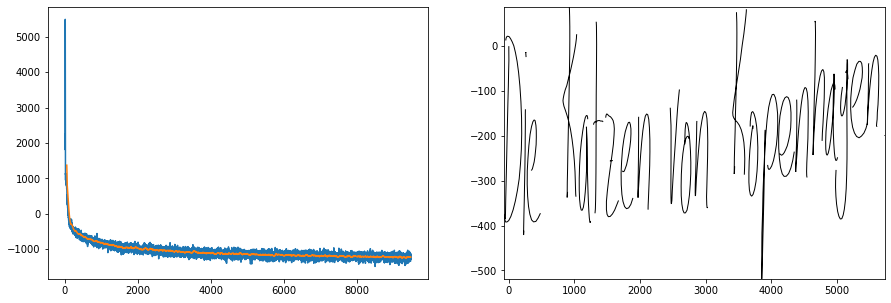

time per minibatch 3.6412975788116455
49 / 180 (of 208) : -1158.1607666015625
epoch 49 took 692.2666292190552 seconds


In [21]:
for epoch in range(50):
    lasttime = time.time()
    lastbatch = -1
    epochstart = lasttime
    for batch,i in enumerate(train_it):
        #i_seq_pt, i_seq_tg, i_seq_mask, i_seq_str, i_seq_str_mask = [torch.autograd.Variable(torch.from_numpy(i).cuda()) for i in inputs]
        #i_seq_str = i_seq_str.long()
        i_seq_pt = torch.stack([i.xs, i.ys, i.pen.float()], dim=2).cuda()
        i_seq_tg = i_seq_pt[1:].cuda()
        i_seq_pt = i_seq_pt[:-1].cuda()
        i_seq_mask = (i.pen[:-1]>=0).float().cuda()
        i_seq_str = i.txtn.cuda()
        i_seq_str_mask = i.txtmask.cuda()
        
        opt.zero_grad()
        res = m(i_seq_pt, i_seq_mask, i_seq_tg, i_seq_str, i_seq_str_mask)
        res.backward()
        losses.append(res.data)
        if batch % 10 == 0:
            losses = [float(l) for l in losses]
            IPython.display.clear_output(wait=True)
            pyplot.figure(figsize=(15,5))
            pyplot.subplot(1,2,1)
            pyplot.plot(losses)
            if len(losses)>=50:
                smoothed = (numpy.convolve(losses,numpy.ones(50)/50,'valid'))
                pyplot.plot(numpy.arange(len(losses)-len(smoothed),len(losses)),smoothed)
                print ("smoothloss", smoothed[-1])
            pyplot.subplot(1,2,2)
            with torch.no_grad():
                i_seq_str = torch.autograd.Variable(torch.LongTensor([int(char_dict[c]) for c in "Die Katzen von Kopenhagen. "]).view(-1,1).cuda())
                i_seq_str_mask = torch.autograd.Variable(torch.ones(i_seq_str.size()).cuda())
                seq_pt, seq_mask = m.predict(i_seq_pt[0,:1], i_seq_str, i_seq_str_mask, bias=0.8)
                lengths = seq_mask.sum(0).data.long()
                idx = 0
                show_stroke(seq_pt.data.cpu()[:lengths[idx],idx])
                #''.join([inv_char_dict[c] for c in i_seq_str.data.cpu()[:,idx]])
            pyplot.show()
            print ("time per minibatch",(time.time()-lasttime)/(batch-lastbatch))
            lastbatch = batch
            lasttime = time.time()
            print (epoch,'/', batch,'(of 208) :', res.item())

        torch.nn.utils.clip_grad_norm(m.parameters(),5)
        opt.step()
    print ("epoch", epoch, "took", time.time()-epochstart, "seconds")


Sometimes I miss the output above, so here is the loss graph again.

smoothloss tensor(-1228.5570, device='cuda:0')


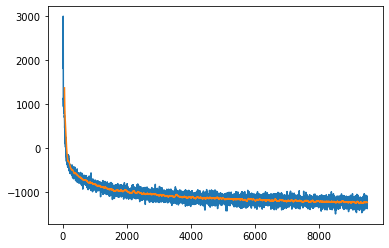

49 / 189 (of 208) : -1156.6083984375


In [22]:
IPython.display.clear_output(wait=True)
pyplot.plot(numpy.fmin(losses,3000))
if len(losses)>=50:
    smoothed = (numpy.convolve(losses,numpy.ones(50)/50,'valid'))
    pyplot.plot(numpy.arange(len(losses)-len(smoothed),len(losses)),numpy.fmin(smoothed,3000))
    print ("smoothloss", smoothed[-1])
pyplot.show()
print (epoch,'/', batch,'(of 208) :', res.item())            


We can evaluate the negative log likelihood on the validation set. We should reach the same ballpark as Graves, who reports -1096.9 for the non-adaptive weight noise, albeit for a three-layer network) in Table 4.

In [26]:
with torch.no_grad():
    totalweight = 0.0
    totalweightedloss = 0.0
    for i in tqdm.tqdm(val_it): #, total=len(val_it)):
        i_seq_pt = torch.stack([i.xs, i.ys, i.pen.float()], dim=2)
        i_seq_tg = i_seq_pt[1:].cuda()
        i_seq_pt = i_seq_pt[:-1].cuda()
        i_seq_mask = (i.pen[:-1]>=0).float().cuda()
        i_seq_str = i.txtn.cuda()
        i_seq_str_mask = i.txtmask.cuda()
        loss = m(i_seq_pt, i_seq_mask, i_seq_tg, i_seq_str, i_seq_str_mask).item()
        lossweight = i.batch_size/val_it.batch_size
        totalweight += lossweight
        totalweightedloss += loss*lossweight
print("Negative log likelihood on validation set", totalweightedloss/totalweight)


100%|██████████| 25/25 [00:43<00:00,  1.73s/it]

Negative log likelihood on validation set -1114.5275350203701


If you want, you can load and save the model with the code below. It is more customary to use torch.save, but sometimes I like to save the weights only.

In [36]:
import h5py
def save_to_hdf5(fn, d):
    f = h5py.File(fn, "w")
    for k,v in d.items():
        f.create_dataset(k, data=v)
def load_from_hdf5(fn):
    f = h5py.File(fn, "r")
    print (list(f.keys()))
    return {k:v[:] for k,v in f.items()}

save_to_hdf5("graves_handwriting_generation_"+time.strftime("%Y-%m-%d-%H-%M",time.localtime())+"epoch_{}".format(epoch)+".hd5", {n:p.data.cpu().numpy() for n,p in m.named_parameters()})
if 0:
    save_to_hdf5("graves_handwriting_generation_"+time.strftime("%Y-%m-%d-%H-%M",time.localtime())+"epoch_{}".format(epoch)+".hd5", {n:p.data.cpu().numpy() for n,p in m.named_parameters()})
if 0:
    d =load_from_hdf5("graves_handwriting_generation_2018-03-13-02-45epoch_49.hd5")
    for n,p in m.named_parameters():
        p.data.copy_(torch.from_numpy(d[n]))

## Visual model evaluation

Nw that we have a model, we may show some samples.
First we use the bias parameter as Graves describes in Section 5.4 and shows in Figure 16.

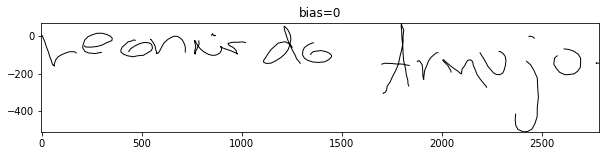

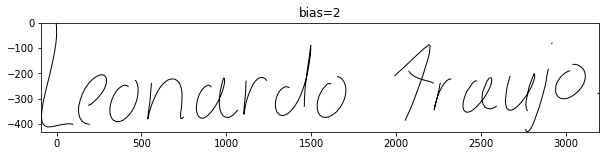

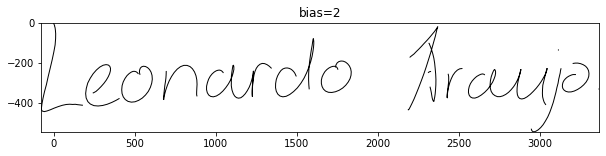

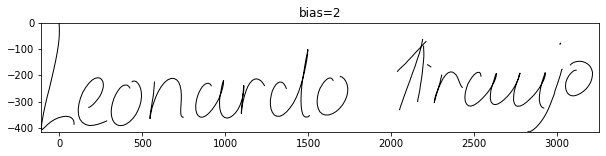

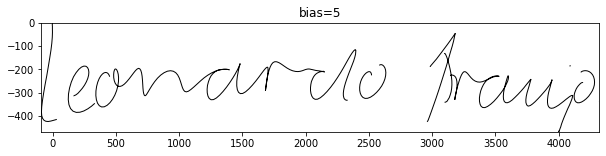

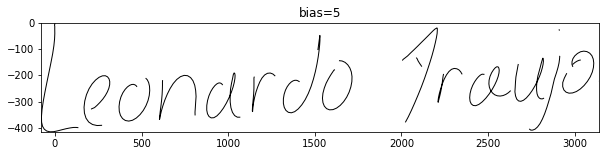

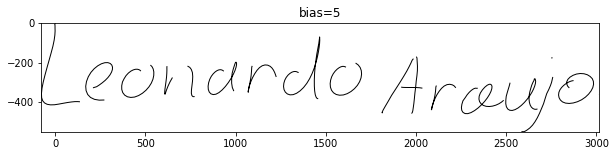

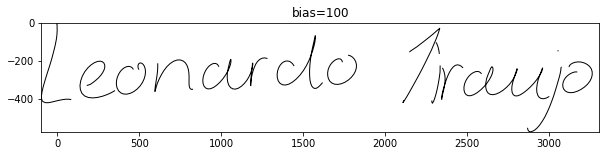

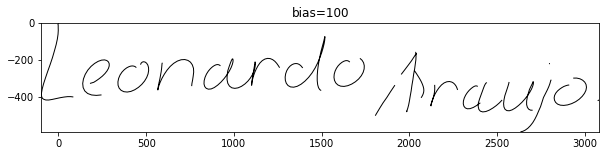

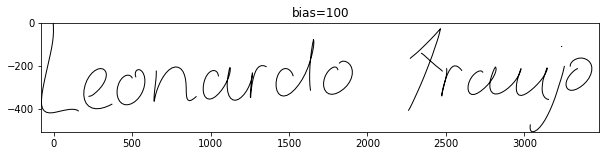

In [28]:
for bias in [0,2,2,2,5,5,5,100,100,100]:
    with torch.no_grad():
        i = next(iter(train_it))
        i_seq_pt = torch.stack([i.xs, i.ys, i.pen.float()], dim=2)
        i_seq_pt = i_seq_pt[:-1].cuda()

        i_seq_str = torch.autograd.Variable(torch.LongTensor([int(char_dict[c]) for c in "Leonardo Araujo. "]).view(-1,1).cuda())
        i_seq_str_mask = torch.autograd.Variable(torch.ones(i_seq_str.size()).cuda())
        seq_pt, seq_mask = m.predict(i_seq_pt[0,:1], i_seq_str, i_seq_str_mask, bias=bias)
        lengths = seq_mask.sum(0).data.long()
        idx = 0
        pyplot.figure(figsize=(10,2))
        show_stroke(seq_pt.data.cpu()[:lengths[idx],idx])
        #''.join([inv_char_dict[c] for c in i_seq_str.data.cpu()[:,idx]])
        pyplot.title("bias={}".format(bias))
        pyplot.show()


Note that even with an extreme bias, the generated writing is not identical. This is in contrast to Graves' observation in Figure 16. I tentatively believe this is due to several modes sharing the top spot for the weights (e.g. two having mass almost exactly 0.5). Also the pen write vs. move probability is not biased.

### Model internal state

In Order to look at model internals, we can a pass a Python defaultdict to the model.

In [30]:
d = collections.defaultdict(list)
with torch.no_grad():
        i = next(iter(train_it))
        i_seq_pt = torch.stack([i.xs, i.ys, i.pen.float()], dim=2).cuda()
        i_seq_tg = i_seq_pt[1:].cuda()
        i_seq_pt = i_seq_pt[:-1].cuda()
        i_seq_mask = (i.pen[:-1]>=0).float().cuda()
        i_seq_str = i.txtn.cuda()
        i_seq_str_mask = i.txtmask.cuda()
        
        opt.zero_grad()
        res = m(i_seq_pt, i_seq_mask, i_seq_tg, i_seq_str, i_seq_str_mask, hidden_dict=d)
d.keys()

dict_keys(['seq_h', 'seq_k', 'seq_w', 'seq_phi', 'pi', 'mean_x', 'mean_y', 'std_x', 'std_y', 'rho', 'bernoulli', 'z', 'loss_per_timestep'])

In [31]:
idx=1
this_batch_size = i_seq_pt.size(1)
pts = i_seq_pt[:i.ptslen[0,idx],idx].cpu()
pts_len = i.ptslen[0,idx]
mean_y = d['mean_y'][0].view(-1,this_batch_size, d['mean_y'][0].size(1))[:pts_len,idx]*train_ds.coord_std[1]+train_ds.coord_mean[1]
mean_x = d['mean_x'][0].view(-1,this_batch_size, d['mean_x'][0].size(1))[:pts_len,idx]*train_ds.coord_std[0]+train_ds.coord_mean[0]
pi   = d['pi'][0].view(-1,this_batch_size, d['pi'][0].size(1))[:pts_len,idx]


The weights of the probabilities look reasonably similar to Graves Figure 14 in that we movements within strokes and in between being sampled from different mixture components.

'The kind of good preached'

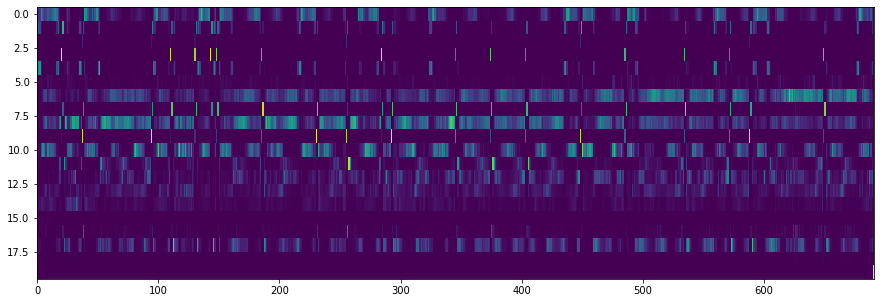

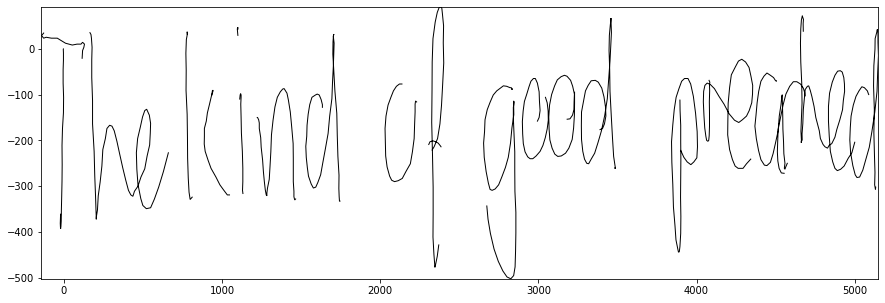

In [32]:
pyplot.figure(figsize=(15,5))
pyplot.imshow(pi.t(), aspect='auto')
#pts = torch.stack([i.xs,i.ys,i.pen.float()],dim=-1)
pyplot.figure(figsize=(15,5))
show_stroke(pts)
txt = train_ds.tensor_to_str(i.txt[:i.txtlen[0,idx],idx])
txt

Next we want to visualize the probability distributions for the points.

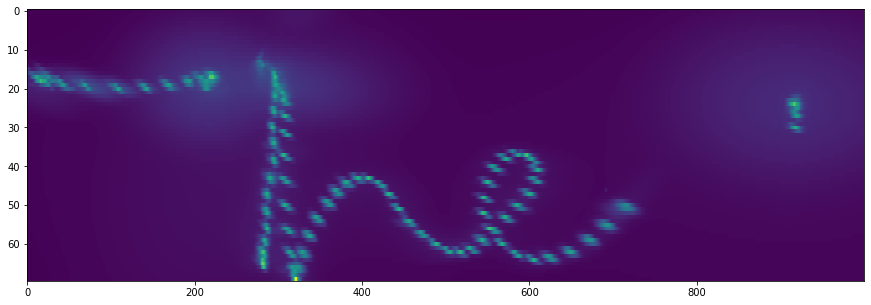

In [33]:
def show_mixture_of_normals(x, y, sx, sy, rho, weights):
    x = x.view(1,1,-1)
    y = y.view(1,1,-1)
    sx = sx.view(1,1,-1)
    sy = sy.view(1,1,-1)
    rho = rho.view(1,1,-1)
    weights = weights.view(1,1,-1)
    xmin, ymin = x.min(), y.min()
    xmax, ymax = x.max(), y.max()
    NX, NY = 1000, 70
    xx = torch.arange(0., NX).view(1,-1,1)*(xmax-xmin)/NX+xmin
    yy = torch.arange(0., NY).view(-1,1,1)*(ymax-ymin)/NY+ymin
    x_s = (x-xx)/sx
    y_s = (y-yy)/sy
    tmp = 1-rho**2
    log_dens = -(x_s**2+y_s**2-2*rho*x_s*y_s)/(2*tmp)-numpy.log(2*numpy.pi)-torch.log(sx)- torch.log(sy) - 0.5*torch.log(tmp)
    dens = (weights*torch.exp(log_dens)).sum(-1)
    pyplot.imshow(dens**0.25, aspect='auto') # note: the **0.25 is only for the color mapping


idx=1
this_batch_size = i_seq_pt.size(1)
pts = i_seq_pt[:i.ptslen[0,idx],idx].cpu()
pts_len = i.ptslen[0,idx]
cut_pts_len = min(pts_len, 100)
mean_x = d['mean_x'][0].view(-1,this_batch_size, d['mean_x'][0].size(1))[:cut_pts_len,idx]*train_ds.coord_std[0]+train_ds.coord_mean[0]
mean_y = d['mean_y'][0].view(-1,this_batch_size, d['mean_y'][0].size(1))[:cut_pts_len,idx]*train_ds.coord_std[1]+train_ds.coord_mean[1]
std_x  = d['std_x'][0].view(-1,this_batch_size,  d['std_x'][0].size(1))[:cut_pts_len,idx]*train_ds.coord_std[0]
std_y  = d['std_y'][0].view(-1,this_batch_size,  d['std_y'][0].size(1))[:cut_pts_len,idx]*train_ds.coord_std[1]
pi     = d['pi'][0].view(-1,this_batch_size,  d['pi'][0].size(1))[:cut_pts_len,idx].contiguous()
rho    = d['rho'][0].view(-1,this_batch_size, d['rho'][0].size(1))[:cut_pts_len,idx].contiguous()
_,maxidx = pi.max(1)
offset_x = torch.cat([torch.zeros(1),mean_x[torch.arange(0,len(mean_x), out=torch.LongTensor()), maxidx].cumsum(0)[:-1]],0)
offset_y = torch.cat([torch.zeros(1),mean_y[torch.arange(0,len(mean_y), out=torch.LongTensor()), maxidx].cumsum(0)[:-1]],0)

if 0:
    NP = 10
    x = torch.randn(NP)
    y = torch.randn(NP)
    sx = torch.exp(-1.5+0.5*torch.randn(NP))
    sy = torch.exp(-1.5+0.5*torch.randn(NP))
    rho = torch.zeros(NP)
    weights = torch.ones(NP)
pyplot.figure(figsize=(15,5))
show_mixture_of_normals(mean_x+offset_x.unsqueeze(1), mean_y+offset_y.unsqueeze(1), std_x, std_y, rho, pi)


In contrast to Figure 14 in Graves, we do not see that much of the increased uncertainty (but note with Graves that in Figure 14 the uncertainty is much smaller for the moves to a new stroke than in the non-conditioned output of Figure 10). This may mean our model is overfitting more than his. Graves uses regularisation with adaptive weighted noise which - to the best of my understanding - is very similar to the recently more popular Bayesian Variational Inference scheme.


We can also recreate figure 13. To illustrate which character is dominant in the attention mechanism, we color the strokes accordingly. (I first saw colored strokes at [David Ha aka Hardmaru's blog](http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/), but at first glance he seems to color strokes, but we colorcode the attentention on chars.) It seems that the model looks at the next character quite early.

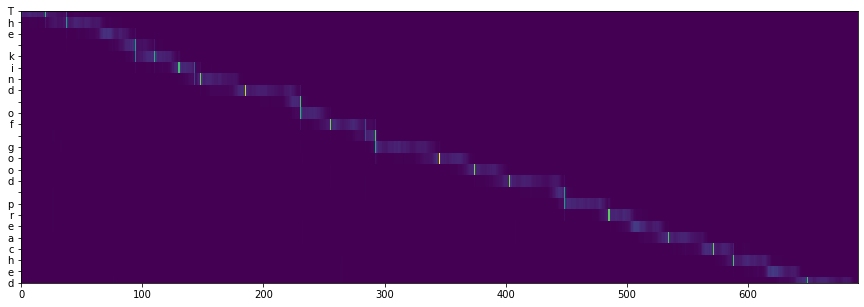

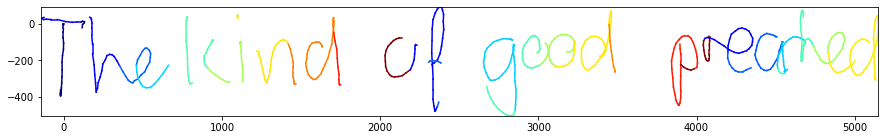

In [34]:
seq_phi  = d['seq_phi'][0][:pts_len,:, idx]
pyplot.figure(figsize=(15,5))
pyplot.imshow(d['seq_phi'][0][:pts_len,:, idx].t(), aspect="auto")
ax = pyplot.gca()
ax.set_yticks(range(i.txtlen[0,idx].item()))
ax.set_yticklabels(list(txt))
pyplot.figure(figsize=(15,2))
colorlist = [pyplot.cm.jet(int(5*i/(seq_phi.size(1)-1)*(pyplot.cm.jet.N-1))%256) for i in range(seq_phi.size(1))]
colors = [colorlist[c] for c in seq_phi.max(1)[1].tolist()]
show_stroke(pts, colors)

I hope you enjoyed the exploration of Graves' classic model as much as I did writing it.

Feedback and corrections are always welcome at <tv@lernapparat.de>, I read and appreciate every mail.

*Thomas Viehmann*